# Contrastive Learning For Normal Distribution

The normal distribution, for a given mean and variance, specifies the probability density to be:

$$f(x) = \frac{1}{\sigma \sqrt{2 \pi}} \cdot e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}$$ 

The function is a normalized statistical model, meaning that the probability desnity funcion integrates to $1$ regardless of what values of $\sigma$ and $\pi$ are used. However, suppose instead we now we have 

$$f(x) = e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2 + c}$$

Now the function no longer itegrates to 1, which poses a problem for MLE estimation of the parameters. Below we use noise contrastive estimation to calculate $\mu, \sigma$, and $c$ for a distribution when we are only given samples of the distribution.

In [20]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sys import exit
import scipy.integrate as integrate
from scipy import optimize


from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.nn import functional as F

In [21]:
true_dist = Normal(0.7, 1.5)
true_samples = true_dist.sample((100000,))

noise_dist = Normal(-1, 2)
noise_samples = noise_dist.sample((100000,))


Now we can plot the histograms of the samples to visual the distributions.

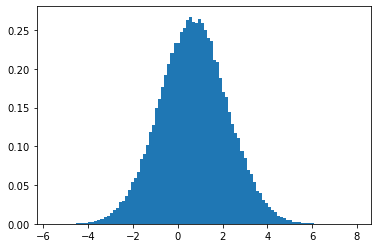

In [22]:
true_samples_np = true_samples.cpu().detach().numpy()
noise_samples_np = noise_samples.cpu().detach().numpy()
plt.hist(true_samples_np, density = True, bins = 100)
plt.show()

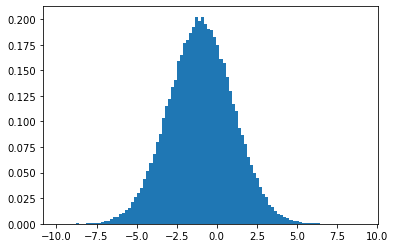

In [23]:
plt.hist(noise_samples_np, density = True, bins = 100)
plt.show()

## Learn Constants $\mu, \sigma, c$

We have a sample of random vectors $x \in \mathbf{R}^d$ which follows an unknown probability density function $p_d(x)$. It is possible to model $p_d(x) = p_m(x; \theta)$ where $\theta$ is a vector of parameters. There exist some parameters $\theta'$ such that $p_d(x) = p_m(x;\theta')$.

However, $\int_{}^{} p_m(x;\theta) dx = 1$.

Even though the contraint can be fufilled in principle by redefining $$p_m(x; \theta) = \frac{p(x;\theta)}{\int_{}^{} p(x;\theta) dx}$$ 

Here, $\int_{}^{} p(x;\theta) dx$ is called the normalizing constant in statistics or partition function in thermodynamics. In pratice, this integral is rarely tractable. 

Noise contrastive estimations defines an estimator that can be estimated by maximizing the objective function. For observed samples $X = (x_1, x_2, ..., x_T)$. We also have $Y = (y_1, y_2, ..., y_T)$ that come from a noise distribution $p_n(x)$. A note below is that we can denote the sigmoid function as $S(x) = \frac{1}{1+e^{-x}}$, such that $h(x; \theta) = S(G(x; \theta))$. Here, the objective function is:

$$J_T(\theta) = \frac{1}{2T} \sum_{t=1}^{T} \ln[ h(x_t; \theta) ] + \ln[1-h(y_t; \theta)] $$

$$h(x; \theta) = \frac{1}{1+e^{-G(x, \theta)}}$$

$$G(x, \theta) = \ln p_m(x; \theta) - \ln p_n(x)$$

Below we can code up all of the functions.

In [24]:
def ln_p_n(x):
    return noise_dist.log_prob(x)

def ln_p_m(x, theta):
    mu, sigma, c = theta[0], theta[1], theta[2]
    ln_p_m = -(x-mu)**2/(2*sigma**2) + c #Normal(mu, sigma).log_prob(x)
    return ln_p_m #+ 0.5*(np.log(2*np.pi) + np.log(sigma)) - c
    
def G_x_theta(x, theta):
    return ln_p_m(x, theta) - ln_p_n(x)

def h_x_theta(x, theta):
    return torch.sigmoid(G_x_theta(x, theta))

def J_T(theta, X_true, Y_true):
    T = X_true.size()[0] + Y_true.size()[0] 
    J_T = torch.sum(torch.log(h_x_theta(X_true, theta)) + torch.log(1 - h_x_theta(Y_true, theta)))
    return -(1/(2*T))*J_T

#print(J_T([0, 1, 1], true_samples, noise_samples))
#print(J_T([0, 0.5, 1], true_samples, noise_samples))
print(optimize.minimize(J_T, x0=[2, 2, 2], args=(true_samples, noise_samples)))
print(np.log(1/(1.5*np.sqrt(2*np.pi))))

      fun: 0.2888045037974613
 hess_inv: array([[23.20862469,  4.99597819,  1.47867517],
       [ 4.99597819,  9.33358149, -5.93482294],
       [ 1.47867517, -5.93482294, 14.88327564]])
      jac: array([-1.28895044e-06, -1.31130219e-06, -5.17442822e-06])
  message: 'Optimization terminated successfully.'
     nfev: 132
      nit: 27
     njev: 33
   status: 0
  success: True
        x: array([ 0.69293571,  1.49816454, -1.32716109])
-1.324403641312837


Above, we see that using NCE allows us to properly learn the values of $\mu, \sigma, c$.

# Learning a General Potential Energy Function

Above, we defined a normal distribtion to be of the form

$$p(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}+c}$$

Here, contrastive learning can find the parameters, $\mu, \sigma, c$. However, what if we instead have a neural network parameterise $U_\theta(x)$, such that we have $p(x) = e^{-U_\theta(x)}$?

In [25]:
class NCE(nn.Module):
    def __init__(self):
        super(NCE, self).__init__()
        self.U_x = nn.Sequential(
          nn.Linear(1, 20),
          nn.Tanh(),
          nn.Linear(20, 100),
          nn.Tanh(),
          nn.Linear(100, 20),
          nn.Tanh(),
          nn.Linear(20, 1),
        )

    def forward(self, x):
        return -self.U_x(x)
        
    def ln_p_m(self, x): #this is U(x)
        return -self.U_x(x)
    
    def ln_p_n(self, x):
        return noise_dist.log_prob(x)
    
    def G_x_theta(self, x):
        return self.ln_p_m(x) - self.ln_p_n(x)

    def h_x_theta(self, x):
        return torch.sigmoid(self.G_x_theta(x))
    
    def loss(self, X_true, Y_true):
        T = X_true.size()[0] + Y_true.size()[0]
        J_T = torch.sum(torch.log(self.h_x_theta(X_true)) + torch.log(1 - self.h_x_theta(Y_true)))
        return -(1/(2*T))*J_T

device = torch.device("cpu")
model = NCE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [26]:
def train(epoch, true_samples, noise_samples):
    model.train()
    train_loss = 0

    #true_samples = true_samples.to(device)
    #noise_samples = noise_samples.to(device)

    t = true_dist.sample((1000,1))
    n = noise_dist.sample((1000,1))

    optimizer.zero_grad()
    
    loss = model.loss(t, n)
    loss.backward()

    train_loss += loss.item()
    optimizer.step()

    print(loss)
    
for epoch in range(1, 2000):
    if epoch % 200 == 0:
        print("Epoch", epoch)
    train(epoch, true_samples, noise_samples)

tensor(0.5707, grad_fn=<MulBackward0>)
tensor(0.5553, grad_fn=<MulBackward0>)
tensor(0.5388, grad_fn=<MulBackward0>)
tensor(0.5290, grad_fn=<MulBackward0>)
tensor(0.5250, grad_fn=<MulBackward0>)
tensor(0.5066, grad_fn=<MulBackward0>)
tensor(0.5017, grad_fn=<MulBackward0>)
tensor(0.4930, grad_fn=<MulBackward0>)
tensor(0.4748, grad_fn=<MulBackward0>)
tensor(0.4614, grad_fn=<MulBackward0>)
tensor(0.4599, grad_fn=<MulBackward0>)
tensor(0.4430, grad_fn=<MulBackward0>)
tensor(0.4255, grad_fn=<MulBackward0>)
tensor(0.4384, grad_fn=<MulBackward0>)
tensor(0.4208, grad_fn=<MulBackward0>)
tensor(0.4190, grad_fn=<MulBackward0>)
tensor(0.4088, grad_fn=<MulBackward0>)
tensor(0.4109, grad_fn=<MulBackward0>)
tensor(0.4174, grad_fn=<MulBackward0>)
tensor(0.4066, grad_fn=<MulBackward0>)
tensor(0.4141, grad_fn=<MulBackward0>)
tensor(0.3913, grad_fn=<MulBackward0>)
tensor(0.3804, grad_fn=<MulBackward0>)
tensor(0.3866, grad_fn=<MulBackward0>)
tensor(0.3879, grad_fn=<MulBackward0>)
tensor(0.3823, grad_fn=<M

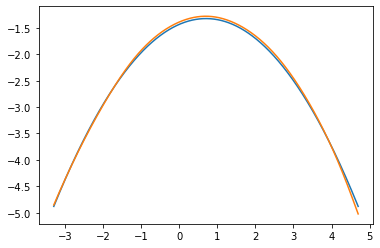

In [29]:
def true_U_x(x, mu, sigma, c):
    return (-(x-mu)**2)/(2*sigma**2) + c
    
lines = np.linspace(-3.3, 4.7, 1000)
mu = 0.7
sigma = 1.5
c = -1.324403641312837

U_x_curve_true = [true_U_x(l, mu, sigma, c) for l in lines]
U_x_curve = [(model(torch.tensor(l).reshape(1,1))).detach().numpy()[0][0] for l in lines]

plt.plot(lines, U_x_curve_true)
plt.plot(lines, U_x_curve)

In [38]:
def U_learned_x(x):
    return np.exp((model(torch.tensor(x).reshape(1,1).to(device))).cpu().detach().numpy()[0][0])

integrate.quad(U_learned_x, -4, 4)[0]

1.0260600824789177